In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util


In [2]:
print(torch.__version__)

2.2.1+cu118


In [3]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, _) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
    
            outputs = model(inputs)
    
            loss = loss_fn(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i,_ in val_loader:
                i = i.to(device)
                o = model(i)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, i).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            best_val_loss = val_loss

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


## Configuration

In [4]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

MODEL_PATH = 'autoencoder_models'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [5]:
from importlib import reload
reload(vcpi_util)

<module 'vcpi_util' from 'd:\\OnlineFolders\\DropBox\\Dropbox\\VCPI 2324\\DL 07\\../util\\vcpi_util.py'>

## Load and prepare MNIST dataset

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

full_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

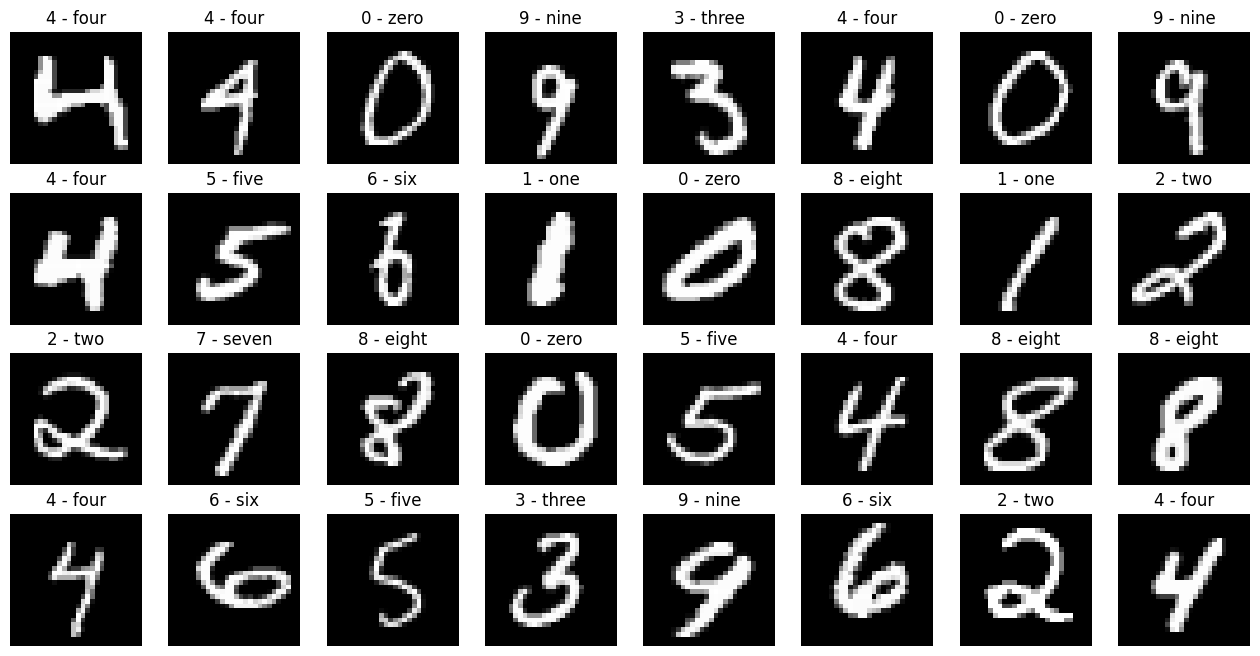

<Figure size 640x480 with 0 Axes>

In [7]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, full_dataset.classes) 